In [2]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue,kGreen, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats,RooAbsReal              

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random

from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
sys.path.append('/home/chasenberg/repos/root_utils/')
from ROOT import TColor
import rootnotes  # For displaying TCanvas in notebooks
from lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   
from root_utils import plot_pulls

In [5]:
from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

In [6]:
mc_path = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file = 'Bd2JpsiKS_random.root'
mc_dir = os.path.join(mc_path, mc_file)

In [7]:
cut_string_mc = ''  #'idxPV==0'
tree_mc = 'Bd2JpsiKS'

In [8]:
signal_dataframe_wrongPV  = rp.read_root(mc_dir,key=tree_mc,where=cut_string_mc, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [9]:
signal_dataframe_wrongPV.columns

Index(['B0_TAGOMEGA_OS', 'B0_TAGDECISION_OS',
       'B0_FitDaughtersConst_status_flat', 'B0_FitDaughtersConst_M_flat',
       'B0_FitDaughtersConst_chi2_flat', 'B0_FitDaughtersConst_IPCHI2_flat',
       'B0_FitDaughtersConst_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_MinIPCHI2anyPV_flat',
       'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_IP_flat',
       'B0_FitDaughtersConst_KS0_P1_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat',
       'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
       'B0_FitDaughtersConst_KS0_decayLength_flat',
       'B0_FitDaughtersConst_KS0_IP_flat', 'B0_FitPVConst_status_flat',
       'B0_FitPVConst_IPCHI2_flat', 'B0_FitPVConst_chi2_flat',
       'B0_FitPVConst_nDOF_flat', 'B0_FitPVConst_tauErr_flat',
       'B0_FitPVConst_tau_flat', 'B0_FitPVConst_MinIPCHI2any

In [10]:
sample = signal_dataframe_wrongPV.sample(122000)

In [11]:
random_set = 'random_sample.root'
sample.to_root(mc_path+random_set,key='Bd2JpsiKS')

### Plot Delta_Tau

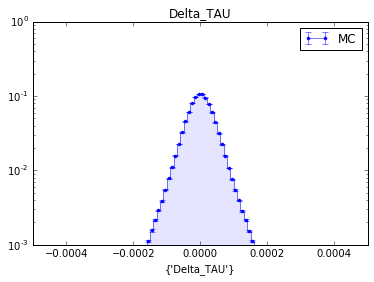

In [12]:
signal_dataframe_wrongPV['Delta_TAU']
p = Plotter('/home/chasenberg/plots/selection/')
p.create_plots(signal_dataframe_wrongPV,'Delta_TAU',component_labels=['MC'])
p['Delta_TAU'].set_log_y()#(-0.0005,0.0005)
a = p['Delta_TAU']
p['Delta_TAU'].set_range(-0.0005,0.0005)
#bdt_plot.plot()
p.plot()

## Build per event resolution model 


In [13]:
#criteria and information for read in mc
data = ROOT.TFile(mc_path+'random_sample.root')
tree_data = data.Get('Bd2JpsiKS') 
tree_data.GetEntries()

122000

## Triple Gaussian

In [14]:
best_pv = True

In [99]:
from ROOT import RooGaussian, RooAddPdf

obsTime = RooRealVar("B0_FitPVConst_tau_flat", "obsTime", 0,0.00025,0.0015, "ps")
obsTimeErr = RooRealVar("B0_FitPVConst_tauErr_flat", "obsTimeErr", 0,-0.001,0.001, "ps")
obsTimeRes = RooRealVar("Delta_TAU", "obsTimeRes", 0,-0.001,0.001, "ps")
idxPV = RooRealVar("idxPV", "idxPV", 0,0,0)

if best_pv==True:
        ntupleVarSet =  RooArgSet(obsTimeErr,obsTimeRes,idxPV)
else:
        ntupleVarSet =  RooArgSet(obsTimeErr,obsTimeRes)#,idxPV)
dataset = RooDataSet('data','data',tree_data,ntupleVarSet)
ROOT.SetOwnership(dataset,False)

#observables = RooArgSet(obsTimeRes, obsTimeErr)
#dataset = RooDataSet("data", "data", tree_data, observables)
#ROOT.SetOwnership(dataset,False)

parResCondMean  = RooRealVar('parResCondMean', 'parResCondMean', 0.0, -5.0, 5.0)
ROOT.SetOwnership(parResCondMean, False)

parResCond_a_1 = RooRealVar('parResCond_a_1', 'parResCond_a_1', 0.0001,0.0001,0.007)
ROOT.SetOwnership(parResCond_a_1, False)
parResCond_b_1 = RooRealVar('parResCond_b_1', 'parResCond_b_1', 0.000005, 0.0000005, 0.0005)
ROOT.SetOwnership(parResCond_b_1, False)


parResCond_a_2 = RooRealVar('parResCond_a_2', 'parResCond_a_2',0.0009,0.0001,0.12)#0.00136,0.00136)
ROOT.SetOwnership(parResCond_a_2, False)
parResCond_b_2 = RooRealVar('parResCond_b_2', 'parResCond_b_2',0.00009, 0.00006, 0.01)
ROOT.SetOwnership(parResCond_b_2, False)


parResCond_a_3 = RooRealVar('parResCond_a_3', 'parResCond_a_3', 0,0,0)
ROOT.SetOwnership(parResCond_a_3, False)
parResCond_b_3 = RooRealVar('parResCond_b_3', 'parResCond_b_3', 0.00035, 0.0003,0.0004)
ROOT.SetOwnership(parResCond_b_3, False)


 


#Definition and calculation of sigma's, related linearly on the decaytime error from the ntuple 
parResCondSigma_1 = RooFormulaVar('parResCondSigma_1', '@0*@1+@2', RooArgList(parResCond_a_1, obsTimeErr, parResCond_b_1))
ROOT.SetOwnership(parResCondSigma_1, False)

parResCondSigma_2 = RooFormulaVar('parResCondSigma_2', '@0*@1+@2', RooArgList(parResCond_a_2, obsTimeErr, parResCond_b_2))
ROOT.SetOwnership(parResCondSigma_2, False)

parResCondSigma_3 = RooFormulaVar('parResCondSigma_3', '@0*@1+@2', RooArgList(parResCond_a_3, obsTimeErr, parResCond_b_3))
ROOT.SetOwnership(parResCondSigma_3, False)
 

#Fractions of particular PDF's  
parResCondFrac_1 = RooRealVar('parResCondFrac_1', 'parResCondFrac_1',0.4, 0.0,0.65 )#0.45, 0,1)
ROOT.SetOwnership(parResCondFrac_1, False)
parResCondFrac_2 = RooRealVar('parResCondFrac_2', 'parResCondFrac_2', 0.31, 0,1)#0.35, 0.0, 1)
ROOT.SetOwnership(parResCondFrac_2, False)
 


#Defition of the four Gaussians     
pdfGaussianCond_1 = RooGaussian('pdfGaussianCond_1', 'pdfGaussianCond_1', obsTimeRes, parResCondMean, parResCondSigma_1)
ROOT.SetOwnership(pdfGaussianCond_1, False)
    
pdfGaussianCond_2 = RooGaussian('pdfGaussianCond_2', 'pdfGaussianCond_2', obsTimeRes, parResCondMean, parResCondSigma_2)
ROOT.SetOwnership(pdfGaussianCond_2, False)
    
pdfGaussianCond_3 = RooGaussian('pdfGaussianCond_3', 'pdfGaussianCond_3', obsTimeRes, parResCondMean, parResCondSigma_3)
ROOT.SetOwnership(pdfGaussianCond_3, False)
 

# including four components -> 4 Gaussians
pdfGaussianCond_sum = RooAddPdf('pdfGaussianCond_sum', 'pdfGaussianCond_sum', RooArgList(pdfGaussianCond_1, pdfGaussianCond_2, pdfGaussianCond_3,  ), RooArgList(parResCondFrac_1,parResCondFrac_2))
ROOT.SetOwnership(pdfGaussianCond_sum, False)


data_model_cond = pdfGaussianCond_sum
data_model_cond.Print('t')

In [100]:
results_dir = '/home/chasenberg/plots/resolution/results/'

parameters_file_name  = 'params_cond.txt'
parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')

if os.path.exists(os.path.join(results_dir, parameters_init_name)):
    print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
    data_model_cond.getParameters(data).readFromFile(os.path.join(results_dir, parameters_init_name))
else:
    print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
    
cond_argset = RooArgSet(obsTimeErr)    


fit_result = data_model_cond.fitTo(dataset, 
                                    RooFit.NumCPU(6),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Save(True),
                                    RooFit.ConditionalObservables(cond_argset)) 

if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
data_model_cond.getParameters(dataset).writeToFile(final_params_file)

INFO: configfile... /home/chasenberg/plots/resolution/results/params_cond_init.txt does not exist
INFO: Fit converged
INFO: Fit complete


In [101]:
print(parResCondMean.getVal())

-4.1528166150328616e-07


In [102]:
print(parResCondFrac_1.getVal()),print(parResCondFrac_2.getVal()) 

0.6499999983903597
0.3448908513645289


(None, None)

In [103]:
print(parResCond_a_1.getVal()),print(parResCond_a_2.getVal()),print(parResCond_a_3.getVal()) 

0.006999999861479405
0.11999999970609121
0.0


(None, None, None)

In [104]:
print(parResCond_b_1.getVal()),print(parResCond_b_2.getVal()),print(parResCond_b_3.getVal()) 

3.020510489179577e-05
6.00000000212237e-05
0.0003332531087866075


(None, None, None)

In [105]:
from ROOT import TColor
from ROOT import RooAbsReal
from ROOT import TGraph, RooList, RooCurve
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style() 

obsTimeRes.setRange('small_range', -0.001,0.001,)
range_name = 'small_range'

def plot_like_a_pro(n_steps, n_bins, range_name, plot_var, data_model, data_set):
    
    min_res   = plot_var.getBinning(range_name).binLow(1)
    max_res   = plot_var.getBinning(range_name).binHigh(n_bins-1)
    increment = (max_res - min_res)/n_steps
    width     = (max_res - min_res)/n_bins
    
    canvas = TCanvas('canvas', 'canvas', 1000, 600)
    frame = plot_var.frame(min_res, max_res)
    data_set.plotOn(frame, ROOT.RooFit.Name('data'))
    
    int_set = RooArgSet('int_set')
    int_set.Print('v')

    norm_set = RooArgSet(data_model.getObservables(data_set))
    norm_set.remove(obsTimeErr, True, True)
    norm_set.Print('v')
   
    RooAbsReal.defaultIntegratorConfig().setEpsAbs(1e-3)
    RooAbsReal.defaultIntegratorConfig().setEpsRel(1e-3)
    
    integral_gauss_1 = pdfGaussianCond_1.createIntegral(int_set, RooFit.NormSet(norm_set), RooFit.Range(range_name))
    integral_gauss_2   = pdfGaussianCond_2.createIntegral(int_set, RooFit.NormSet(norm_set), RooFit.Range(range_name))
    integral_gauss_3    = pdfGaussianCond_3.createIntegral(int_set, RooFit.NormSet(norm_set), RooFit.Range(range_name))
    #integral_gauss_4    = pdfGaussianCond_4.createIntegral(int_set, RooFit.NormSet(norm_set), RooFit.Range(range_name))
    
    value_gauss_1 = 0
    value_gauss_2 = 0
    value_gauss_3 = 0
    value_gauss_4 = 0
    obs_value = min_res+0.5*increment
    
    x_vals = np.zeros(n_steps)
    y_vals = np.zeros(n_steps)
    y_vals_gauss_1 = np.zeros(n_steps)
    y_vals_gauss_2 = np.zeros(n_steps)
    y_vals_gauss_3 = np.zeros(n_steps)
    #y_vals_gauss_4 = np.zeros(n_steps)
    
    entriesintree = data_set.numEntries()
    
    for i in range(0,n_steps):
        #print('step: ' + str(i))
        plot_var.setVal(obs_value)
        value_gauss_1 = 0
        value_gauss_2 = 0
        value_gauss_3 = 0
        value_gauss_4 = 0
        for j in range(0,entriesintree):
            argset = data_set.get(j)
            obsTimeErr.setVal(argset.getRealValue('obsTimeErr'))
            value_gauss_1  += integral_gauss_1.getVal() * width * parResCondFrac_1.getVal()
            value_gauss_2  += integral_gauss_2.getVal() * width * parResCondFrac_2.getVal()
            value_gauss_3  += integral_gauss_3.getVal() * width * ( 1-parResCondFrac_1.getVal()-parResCondFrac_2.getVal())
            #value_gauss_4  += integral_gauss_4.getVal() * width * (1. - parResCondFrac_1.getVal() - parResCondFrac_2.getVal() - parResCondFrac_3.getVal())  
           
        x_vals[i] = obs_value
        y_vals[i] = value_gauss_1 + value_gauss_2 +value_gauss_3
        y_vals_gauss_1[i] = value_gauss_1
        y_vals_gauss_2[i] = value_gauss_2
        y_vals_gauss_3[i] = value_gauss_3
        #y_vals_gauss_4[i] = value_gauss_4
        obs_value += increment
        
    graph        = ROOT.TGraph(len(x_vals), x_vals, y_vals)
    graph_one = ROOT.TGraph(len(x_vals), x_vals, y_vals_gauss_1)
    graph_two   = ROOT.TGraph(len(x_vals), x_vals, y_vals_gauss_2)
    graph_three    = ROOT.TGraph(len(x_vals), x_vals, y_vals_gauss_3)
    #graph_four    = ROOT.TGraph(len(x_vals), x_vals, y_vals_gauss_4)

    one_list = ROOT.RooList()
    one_list.Add(graph_one)
    one_curve = ROOT.RooCurve()
    one_curve.Merge(one_list)
    one_curve.SetLineStyle(2)
    one_curve.SetLineColor(kRed)
    frame.addPlotable(one_curve, 'same')

    two_list = ROOT.RooList()
    two_list.Add(graph_two)
    two_curve = ROOT.RooCurve()
    two_curve.Merge(two_list)
    two_curve.SetLineStyle(3)
    two_curve.SetLineColor(kBlue)
    frame.addPlotable(two_curve, 'same')

    three_list = ROOT.RooList()
    three_list.Add(graph_three)
    three_curve = ROOT.RooCurve()
    three_curve.Merge(three_list)
    three_curve.SetLineStyle(8)
    three_curve.SetLineColor(kGreen)
    frame.addPlotable(three_curve, 'same')
    '''
    four_list = ROOT.RooList()
    four_list.Add(graph_four)
    four_curve = ROOT.RooCurve()
    four_curve.Merge(four_list)
    four_curve.SetLineStyle(8)
    four_curve.SetLineColor(96)
    frame.addPlotable(four_curve, 'same')'''
    
    curve_list = ROOT.RooList()
    curve_list.Add(graph)
    curve = ROOT.RooCurve()
    curve.Merge(curve_list)
    curve.SetLineColor(1)
    frame.addPlotable(curve, 'same')

    #frame.SetMinimum(0)
    #frame.SetMaximum(20)

    # Plot pulls
    legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
    legend.AddEntry(frame.findObject('data'), 'MC', 'p')
    subdir = '/home/chasenberg/plots/resolution/'
    plotname = 'resolution_bestpv'
    can, _ = plot_pulls(plotname, frame , save_path= subdir , logy=True) 
    print('INFO: Finish plotting', flush=True)  
    return(can)    


INFO: Finish plotting


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can


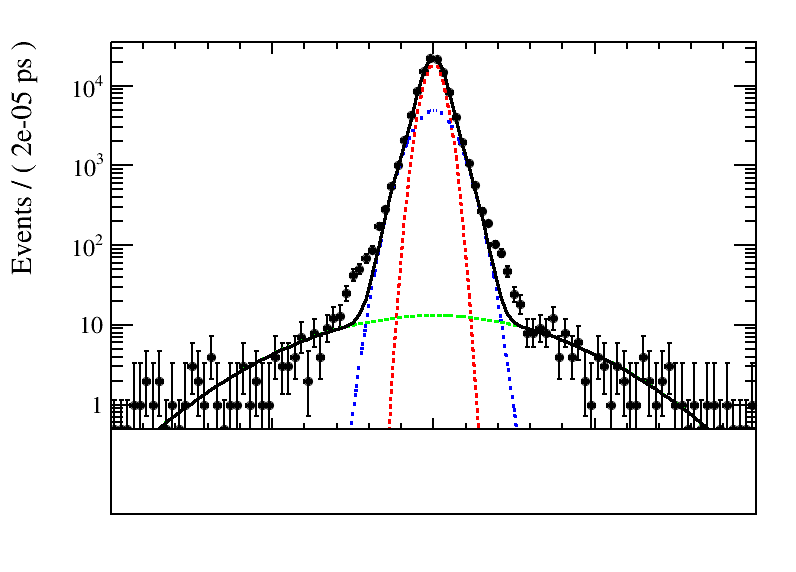

In [106]:
plot_like_a_pro(100, 100, range_name, obsTimeRes, data_model_cond, dataset)

In [107]:
y_narrow = {}
y_wide   = {}
y_frac   = {}

In [108]:
import collections

iter = data_model_cond.getParameters(dataset).createIterator()
var = iter.Next()
while var:
    #print(var.GetName())
    if 'Sigma_wide' in var.GetName():
        #print('Save value and error of {} to list'.format(var.GetName()), flush=True)
        y_wide[var.GetName().strip( 'parResSigma_2' )] = [var.getValV(),var.getError()]
    if 'Sigma_narrow' in var.GetName():
        #print('Save value and error of {} to list'.format(var.GetName()), flush=True)
        y_narrow[var.GetName().strip( 'parResSigma_1' )] = [var.getValV(),var.getError()] 
    if 'parResFrac_wide' in var.GetName():
        #print('Save value and error of {} to list'.format(var.GetName()), flush=True)
        y_frac[var.GetName().strip( 'parResFrac_2' )] = [var.getValV(),var.getError()]      
    var=iter.Next()
    
def get_key(key):
    try:
        return int(key)
    except ValueError:
        return key
    
y_narrow_od = collections.OrderedDict(sorted(y_narrow.items(), key=lambda t: get_key(t[0])))
y_wide_od = collections.OrderedDict(sorted(y_wide.items(), key=lambda t: get_key(t[0])))
y_frac_od = collections.OrderedDict(sorted(y_frac.items(), key=lambda t: get_key(t[0])))
    
#y_narrow_od = collections.OrderedDict(sorted(y_narrow.items()))    
#y_wide_od = collections.OrderedDict(sorted(y_wide.items()))   

In [109]:
y_values_narrow, y_errors_narrow = [v[0] for v in y_narrow_od.values()], [v[1] for v in y_narrow_od.values()]
y_values_wide, y_errors_wide = [v[0] for v in y_wide_od.values()], [v[1] for v in y_wide_od.values()]
y_values_frac, y_errors_frac = [v[0] for v in y_frac_od.values()], [v[1] for v in y_frac_od.values()]

In [110]:
plt.errorbar(x_values, y_values_narrow, xerr=0, yerr=y_errors_narrow, marker='o', color='r', ls='')

NameError: name 'x_values' is not defined

In [ ]:
plt.errorbar(x_values, y_values_wide, xerr=0, yerr=y_errors_wide, marker='o', color='r', ls='')

### Narrow Gaussian

In [ ]:
from scipy.optimize import curve_fit

def line(x, a, b):
    return a * x + b

def parabel(x, a, b, c):
    return c * x * x + a * x + b

In [ ]:
popt, pcov = curve_fit(line, x_values, y_values_narrow, sigma=y_errors_narrow)

In [ ]:
print("a =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)

In [ ]:
plt.errorbar(x_values, y_values_narrow, xerr=0, yerr=y_errors_narrow, marker='o', color='r', ls='')
xfine = np.linspace(0., 0.1, 20)  # define values to plot the function for
fig = plt.plot(xfine, line(xfine, popt[0], popt[1]), 'r-')
plt.xlabel('decay time error [ps]')
plt.ylabel('decay time resolution [ps]')
#plt.show()
plt.savefig(subdir + '/plots/narrow_gaussian.pdf')

### Wide Gaussian

In [ ]:
popt, pcov = curve_fit(line, x_values, y_values_wide, sigma=y_errors_wide)

In [ ]:
print("a =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)

In [ ]:
plt.errorbar(x_values, y_values_wide, xerr=0, yerr=y_errors_wide, marker='o', color='b', ls='')
xfine = np.linspace(0., 0.1, 20)  # define values to plot the function for
fig = plt.plot(xfine, line(xfine, popt[0], popt[1]), 'b-')
plt.xlabel('decay time error [ps]')
plt.ylabel('decay time resolution [ps]')
#plt.show()
plt.savefig(subdir + '/plots/wide_gaussian.pdf')

In [ ]:
popt_p, pcov_p = curve_fit(parabel, x_values, y_values_wide, sigma=y_errors_wide)

In [ ]:
print("a =", popt_p[0], "+/-", pcov_p[0,0]**0.5)
print("b =", popt_p[1], "+/-", pcov_p[1,1]**0.5)
print("c =", popt_p[2], "+/-", pcov_p[2,2]**0.5)

plt.errorbar(x_values, y_values_wide, xerr=0, yerr=y_errors_wide, marker='o', color='b', ls='')
xfine = np.linspace(0., 0.1, 20)  # define values to plot the function for
plt.plot(xfine, parabel(xfine, popt_p[0], popt_p[1], popt_p[2]), 'b-')
plt.xlabel('decay time error [ps]')
plt.ylabel('decay time resolution [ps]')
#plt.show()
plt.savefig(subdir + '/plots/wide_gaussian_quadratic.pdf')